In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import statsmodels.api as sm

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import seaborn as sns

In [264]:
import warnings
warnings.filterwarnings("ignore")

## Processing

In [209]:
df = pd.read_csv('OFFERING.tsv', sep='\t')
df.SALE_DATE = df.SALE_DATE.astype('datetime64')

## Q: How does the relationship between the total amount sold and the total number of people who have already invested vary with the sale date?

### Variables of interest: 
`SALEDATE`, `TOTALAMOUNTSOLD`, `TOTALNUMBERALREADYINVESTED`

We perform log transformation on `TOTALAMOUNTSOLD`, `TOTALNUMBERALREADYINVESTED` because the scale difference is huge for both varaibles.

In [214]:
# log transformation
df['amount'] = np.log(df['TOTALAMOUNTSOLD'] + 1)
df['invested'] = np.log(df['TOTALNUMBERALREADYINVESTED'] + 1)

We will pull a subset of data where sale date is not null. That is about 83.4% of original dataset.

In [215]:
data = df.loc[df['SALE_DATE'].notnull(),]
salenull = df.loc[df['SALE_DATE'].isnull(),]

In [213]:
data.shape[0] / df.shape[0]

0.8343553957848735

In [218]:
# Restore dataset
df = df.drop(columns=['amount', 'invested'])

### Univariate distributions

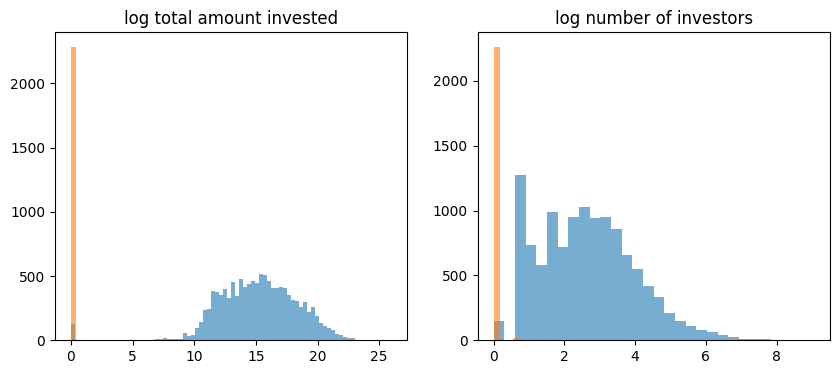

In [278]:
figure, axis = plt.subplots(1, 2, figsize = (10,4))

axis[0].hist(data['amount'], bins = 80, alpha =0.6)
axis[0].hist(salenull['amount'], bins = 50, alpha =0.6)
axis[0].set_title('log total amount invested')

axis[1].hist(data['invested'], bins = 30, alpha =0.6)
axis[1].hist(salenull['invested'], bins = 30, alpha =0.6)
axis[1].set_title('log number of investors')
plt.show()

The variable distributions of each dataset is quite dissimilar. Note the majority of observations from `salenull` are close to zero. For `TOTALAMOUNTSOLD`, two distributions seem quite distinct. 

These observations may be considered as a special group, in the sense that little variation in `TOTALAMOUNTSOLD` are accompanied with large variation in `TOTALNUMBERALREADYINVESTED`, and vice versa.

From the next time series plots, we can see observations that have `TOTALAMOUNTSOLD` or `TOTALNUMBERALREADYINVESTED` values close to zero tend to occur frequently in 2015-2022.

### Time series of amount sold and number invested

In [230]:
# Get x-ticks for time series data
init = min(data['SALE_DATE'])
date_sorted = data['SALE_DATE'].sort_values()
ind = date_sorted.index

x = [(d - init).days for d in data['SALE_DATE']]
x_sorted = [(d - init).days for d in date_sorted]

In [231]:
t = np.array([0, 5, 31, 110, 324, 698, 1552, 11836])
tick = date_sorted[ind[t]]

In [234]:
out_amount = sm.nonparametric.lowess(data['amount'], x, frac=0.2)
out_invested = sm.nonparametric.lowess(data['invested'], x, frac=0.2)

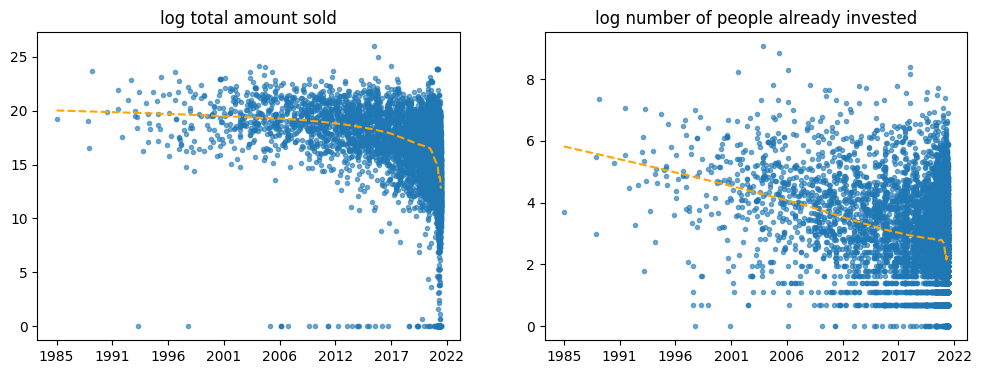

In [246]:
figure, axis = plt.subplots(1, 2, figsize = (12,4))

axis[0].scatter(x, data['amount'], marker = '.', alpha = 0.6)
axis[0].set_xticks(np.arange(0,14001,2000))
axis[0].set_xticklabels(tick.dt.year)
axis[0].plot(out_amount[:,0],out_amount[:,1], ls = '--', c= 'orange')
axis[0].set_title('log total amount sold')

axis[1].scatter(x, data['invested'], marker = '.', alpha = 0.6)
axis[1].plot(out_invested[:,0],out_invested[:,1], ls = '--', c= 'orange')
axis[1].set_title('log number of people already invested')

plt.xticks(np.arange(0,14001,2000), tick.dt.year)
plt.show()

### Creating time bins for data

We create four time bins and divide observations according to `SALE_DATE`. The endpoint inclusive time periods will be 1985-1994, 1995-2004, 2005-2014, 2015-2022. The frequency of observations appears to increase exponentially across time and we have least data from 1985-1994, which has 24 data points.

Since we observe that the coincidence between more recent sale dates and close-to-zero values of `TOTALAMOUNTSOLD` or `TOTALNUMBERALREADYINVESTED`, we hypothesize that many observations from `nullsale` dataset will fall into the last time bin.

In [249]:
# Time cutoffs
t15 = datetime.strptime('2015-01-01', '%Y-%m-%d')
t05 = datetime.strptime('2005-01-01', '%Y-%m-%d')
t95 = datetime.strptime('1995-01-01', '%Y-%m-%d')

mask15 = data['SALE_DATE'] >= t15
mask05 = (data['SALE_DATE'] >= t05) & (data['SALE_DATE'] < t15)
mask95 = (data['SALE_DATE'] >= t95) & (data['SALE_DATE'] < t05)

In [254]:
# Initialize time bin column
data.loc[:, 'TIMEBIN'] = 0
data.loc[mask95, 'TIMEBIN'] = 1
data.loc[mask05, 'TIMEBIN'] = 2
data.loc[mask15, 'TIMEBIN'] = 3
data['TIMEBIN'] = data['TIMEBIN'].astype('category')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [258]:
#amountsold.groupby(date.dt.month).count().plot(kind = "bar")
#amountsold.groupby(date.dt.year).count().plot(kind = "bar")
#plt.xlabel('month')
#plt.show()

### Cross sectional relationship of amount and number of investors

In [261]:
# Nonparametric regression
lowout15 = sm.nonparametric.lowess(data.loc[data['TIMEBIN'] == 3, 'invested'], 
                                   data.loc[data['TIMEBIN'] == 3, 'amount'], frac=0.3)
lowout05 = sm.nonparametric.lowess(data.loc[data['TIMEBIN'] == 2, 'invested'], 
                                   data.loc[data['TIMEBIN'] == 2, 'amount'], frac=0.6)
lowout95 = sm.nonparametric.lowess(data.loc[data['TIMEBIN'] == 1, 'invested'], 
                                   data.loc[data['TIMEBIN'] == 1, 'amount'], frac=0.6)
lowout85 = sm.nonparametric.lowess(data.loc[data['TIMEBIN'] == 0, 'invested'], 
                                   data.loc[data['TIMEBIN'] == 0, 'amount'], frac=0.7)

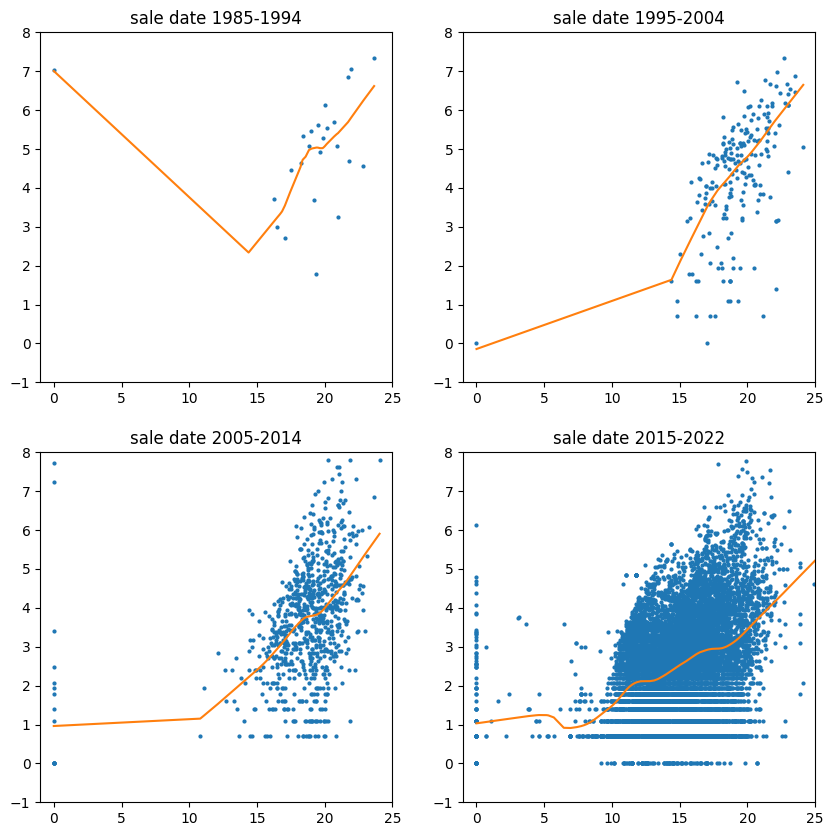

In [275]:
figure, axis = plt.subplots(2, 2, figsize = (10,10))

axis[0, 0].plot(amountsold[mask85], invested[mask85],
         marker='.', ms=4, linestyle="none")
axis[0, 0].plot(lowout85[:,0],lowout85[:,1])

axis[0, 0].set_title("sale date 1985-1994")
axis[0, 0].set_xlim((-1,25))
axis[0, 0].set_ylim((-1,8))

axis[0, 1].plot(amountsold[mask95], invested[mask95],
         marker='.', ms=4, linestyle="none")
axis[0, 1].plot(lowout95[:,0],lowout95[:,1])
axis[0, 1].set_title("sale date 1995-2004")
axis[0, 1].set_xlim((-1,25))
axis[0, 1].set_ylim((-1,8))

axis[1, 0].plot(amountsold[mask05], invested[mask05],
         marker='.', ms=4, linestyle="none")
axis[1, 0].plot(lowout05[:,0],lowout05[:,1])
axis[1, 0].set_title("sale date 2005-2014")
axis[1, 0].set_xlim((-1,25))
axis[1, 0].set_ylim((-1,8))

axis[1, 1].plot(amountsold[mask15], invested[mask15],
         marker='.', ms=4, linestyle="none")
axis[1, 1].plot(lowout15[:,0],lowout15[:,1])
axis[1, 1].set_title("sale date 2015-2022")
axis[1, 1].set_xlim((-1,25))
axis[1, 1].set_ylim((-1,8))

plt.show()

From the fitting line of nonparametric regression, there seems to be a positive correlation across time between the total amount sold and the total number of investors already invested. 

The plots show increasing variance in more recent time periods. A greater number of small offering sales happened in 2015-2022. For a fixed number of investors, the range of total amount sold is growing wider from time period 2005-2014 to 2015-2022. Though the change is unclear for earlier times due to lack of data points.

Comparing the slope of regression curves across time, we do not see obvious differences in the first two decades. In 2005-2014, the curve is more flat compared to that of last ten years. The least steep curve is displayed in 2015-2022, suggesting an increase of amount sold of offerings may see less an increase in number of investors. Possible explanations may be the growing capital of investors over the time.

### Seasonal impacts of sale dates

In [270]:
# Initialize quarter column
data = data.assign(QUARTER = lambda x: ((x['SALE_DATE'].dt.month - 1) // 3))

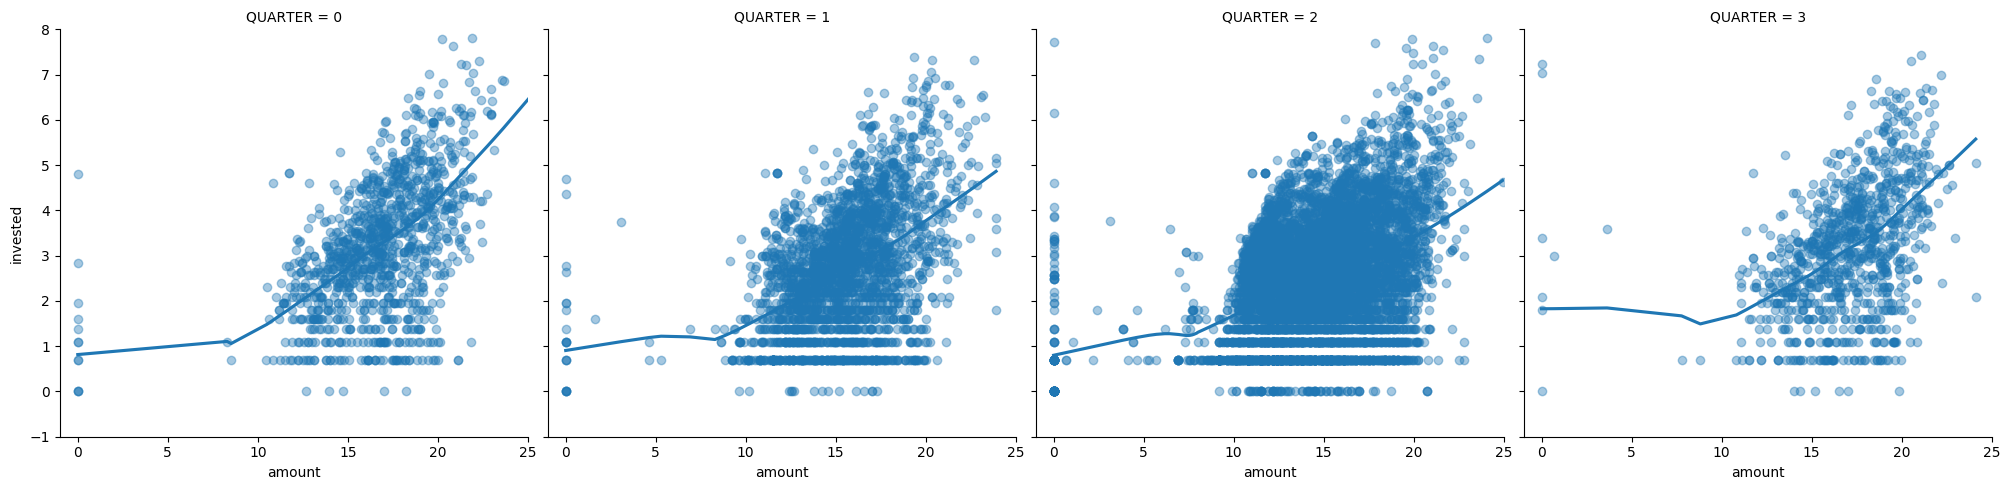

In [273]:
p = sns.lmplot(data=data, x='amount', y='invested',
               col='QUARTER', legend=True, lowess=True, scatter_kws={'alpha':0.4})
p.set(ylim = (-1,8))
p.set(xlim = (-1,25))
plt.show()

Note the highest number of offerings set sale dates in the third quarter while the slope of the fitted curve is most flat. The first quarter has a noticeably steeper slope, which could mean less investors are willing to make a big amount of purchases in first quarter.

### Zero amount and zero invested samples

In [281]:
zero_ind = (data['amount'] == 0) | (data['invested'] == 0)
dfzero = data.loc[zero_ind,]

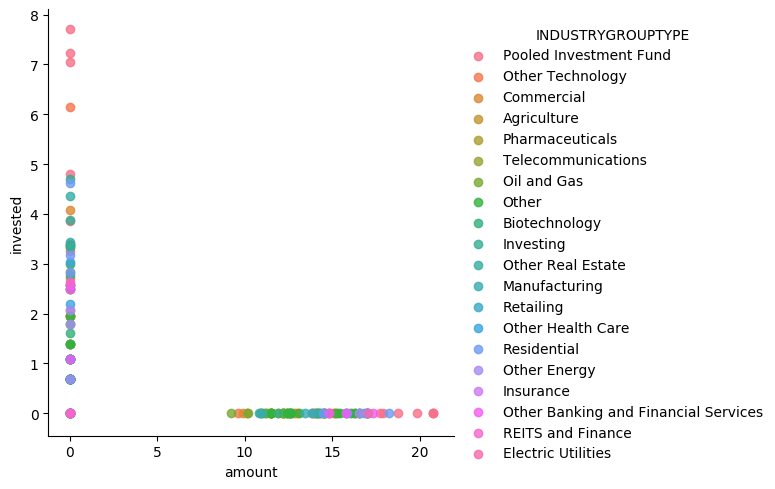

In [282]:
sns.lmplot(x='amount', y='invested', data=dfzero, hue='INDUSTRYGROUPTYPE', fit_reg=False)
plt.show()

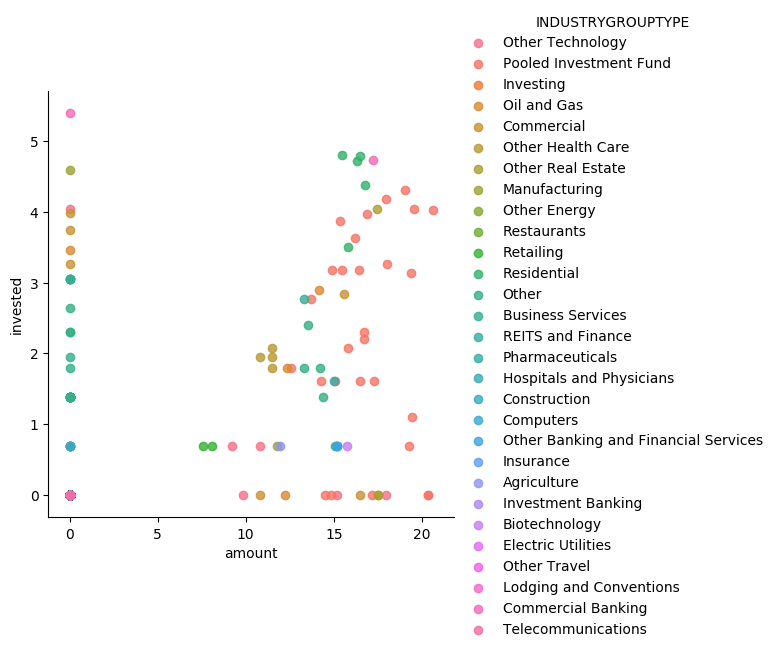

In [284]:
sns.lmplot(x='amount', y='invested', data=salenull, hue='INDUSTRYGROUPTYPE', fit_reg=False)
plt.show()